D:\Miniconda\envs\DL\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


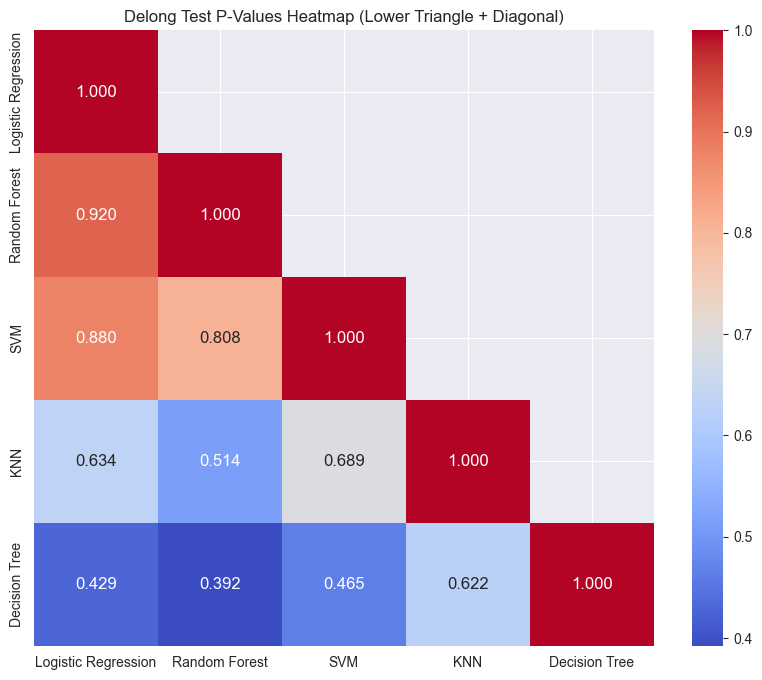

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
tData_train = pd.read_csv("data/ttest_data.csv", encoding='utf-8-sig')
select_features = []
with open("./data/五折/features.txt", "r") as f:
    for feature in f.readlines():
        select_features.append(str(feature).strip())

X = tData_train[select_features]
y = tData_train['label']

# 分割数据
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 数据标准化
scaler_standard = StandardScaler()
X_train_standard = scaler_standard.fit_transform(X_train)
X_test_standard = scaler_standard.transform(X_test)

# 定义模型
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=0),
    "SVM": SVC(probability=True, random_state=0),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=0)
}

roc_aucs = {}
y_pred_probas = {}

# 训练模型并计算AUC
for name, model in models.items():
    model.fit(X_train_standard, y_train)
    y_pred_proba = model.predict_proba(X_test_standard)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    roc_aucs[name] = roc_auc
    y_pred_probas[name] = y_pred_proba

# DeLong检验
def delong_roc_test(y_true, y_pred1, y_pred2):
    auc_diff = roc_auc_score(y_true, y_pred1) - roc_auc_score(y_true, y_pred2)
    var_diff = np.var(y_pred1 - y_pred2)
    z_score = auc_diff / np.sqrt(var_diff + 1e-8)  # 防止分母为0
    p_value = 2 * (1 - norm.cdf(np.abs(z_score)))
    return p_value

# 计算p值矩阵
model_names = list(models.keys())
p_values = np.ones((len(model_names), len(model_names)))

for i, name1 in enumerate(model_names):
    for j, name2 in enumerate(model_names):
        if i >= j:  # 保留左下半区和对角线
            if i != j:
                p_values[i, j] = delong_roc_test(y_test, y_pred_probas[name1], y_pred_probas[name2])

# 创建掩码，仅遮蔽右上半区
mask = np.zeros_like(p_values, dtype=bool)
mask[np.triu_indices_from(mask, k=1)] = True

# 绘制热力图，显示每个格子的p值
plt.figure(figsize=(10, 8))
sns.heatmap(p_values, mask=mask, annot=True, fmt=".3f", xticklabels=model_names, yticklabels=model_names, cmap='coolwarm', cbar=True, annot_kws={"size": 12})

plt.title("Delong Test P-Values Heatmap (Lower Triangle + Diagonal)")
plt.show()
